### Part 1 Find the shortest path 

See node data in the attached .txt file. The first line in the file shows the number of nodes and the number of arcs in the network. Thus, there are a total of 8 nodes and 16 arcs. We label the nodes 1 through 8. Each line in the rest of the file corresponds to an arc. In each line, the first entry corresponds to the origin node of the arc. The second entry corresponds to the destination node of the arc. The third entry corresponds to the length/cost of the arc. Thus, the second line in the file corresponds to an arc from node 1 to node 2 with a length/cost of 1. The last line in the file corresponds to an arc from node 7 to node 8 with a length/cost of 6.

In [112]:
from gurobipy import *

st_node = 8
ed_node = 8

cost = [[0 for j in range(ed_node)] for i in range(st_node)]
cost[0][1] = 1
cost[0][2] = 2
cost[1][2] = 1
cost[1][3] = 5
cost[1][4] = 2
cost[2][3] = 2
cost[2][4] = 1
cost[2][5] = 4
cost[3][4] = 3
cost[3][5] = 6
cost[3][6] = 8
cost[4][5] = 3
cost[4][6] = 7
cost[5][6] = 5
cost[5][7] = 2
cost[6][7] = 6

myModel = Model('shortestpath')

myvar = [[0 for j in range(ed_node)] for i in range(st_node)]
for i in range(st_node):
    for j in range(ed_node):
        decvar = myModel.addVar(vtype = GRB.CONTINUOUS, name = 'x' + str(i+1) + str(j+1))
        myvar[i][j] = decvar
myModel.update()

objExpr = LinExpr()
for i in range(st_node):
    for j in range(ed_node):
        decvar = myvar[i][j]
        objExpr += cost[i][j] * decvar
myModel.setObjective(objExpr, GRB.MINIMIZE)

result = [1,0,0,0,0,0,0,-1]

for i in range(st_node):
    const_Expr = LinExpr()
    for j in range(ed_node):
        if cost[i][j] != 0:
            decvar = myvar[i][j]
            const_Expr += 1 * decvar
    for j in range(ed_node):
        if cost[j][i] != 0:
            decvar = myvar[j][i]
            const_Expr += (-1) * decvar
    myModel.addConstr( lhs = const_Expr , sense = GRB.EQUAL , rhs = result[i] , name = "t" + str( i+1 )  )            
            
myModel.update()

myModel.write(filename = 'shortestpath_Op.lp')

myModel.optimize()

curStatus = myModel.status
if curStatus in (GRB.Status.INF_OR_UNBD, GRB.Status.INFEASIBLE, \
              GRB.Status.UNBOUNDED):
    print( "Could not find the optimal solution" )
    exit(1)

print( "\nOptimal Objective: " + str( myModel.ObjVal ) )
print( "\nOptimal Solution:" )
myVars = myModel.getVars()
for curVar in myVars:
    print ( curVar.varName + " " + str( curVar.x ) )


Optimize a model with 8 rows, 64 columns and 32 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2 rows and 50 columns
Presolve time: 0.02s
Presolved: 6 rows, 14 columns, 28 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9920000e+00   2.004000e+00   0.000000e+00      0s
       3    8.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.05 seconds
Optimal objective  8.000000000e+00

Optimal Objective: 8.0

Optimal Solution:
x11 0.0
x12 0.0
x13 1.0
x14 0.0
x15 0.0
x16 0.0
x17 0.0
x18 0.0
x21 0.0
x22 0.0
x23 0.0
x24 0.0
x25 0.0
x26 0.0
x27 0.0
x28 0.0
x31 0.0
x32 0.0
x33 0.0
x34 0.0
x35 1.0
x36 0.0
x37 0.0
x38 0.0
x41 0.0
x42 0.0
x43 0.0
x44 0.0
x45 0.0
x46 0.0
x47 0.0
x48 0.0
x51 0.0
x52 0.0
x53 0.0
x54 0.0
x55 0.0
x56 1.0
x57 0.0
x58 0.0
x61 0.0
x62 0.0
x63 0.0
x64 0.0
x65 0.0
x66 0.0


### Part 2 Minimized cost in a supply chain

<center><div>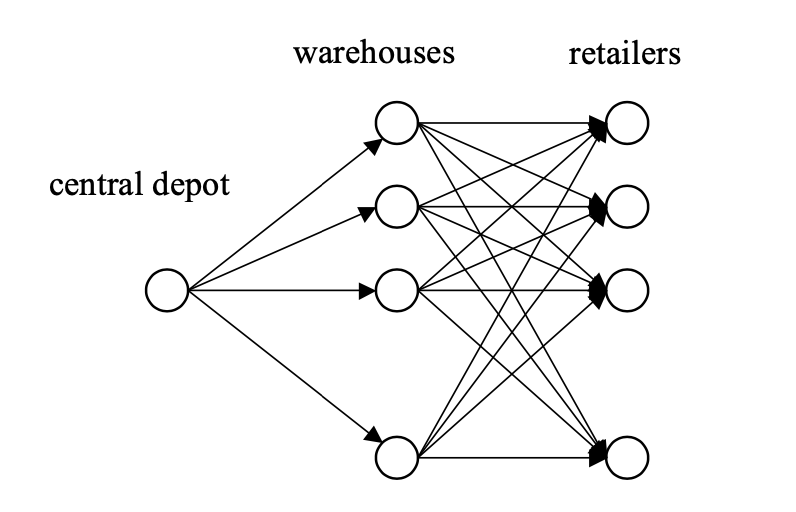</div></center>

The figure above shows the supply chain of a company, where the products at the central depot are shipped to one of the 10 warehouses. The demand at each of the 15 retailers is satisfied from the products shipped from the warehouses. There are 615 units of product available at the central depot. Due to shipment capacities, we can ship at most 10 units of product from each warehouse to each retailer. (In other words, there is an upper bound of 10 on the flow over the arc from each warehouse to each retailer.) In the attached text file, we have the data on the cost of shipping one unit from the central depot to each warehouse, the cost shipping one unit from each warehouse to each retailer, and the demand at each retailer.
<br>

Formulate a linear program that minimizes the total cost of shipping products from the central depot to the warehouses and from the warehouses to the retailers, so that the product availability at the central depot is not violated and the demand at each retailer is satisfied.

In [114]:
from gurobipy import *
import numpy as np
   
with open('supply_chain_data.txt') as f:
    mylist = [line.rstrip('\n') for line in f]
mylist = np.array(mylist)  
    
w_node = 10
r_node = 15

og_w_cost = mylist[1].split('\t')

w_r_cost = [[0 for j in range(r_node)] for i in range(w_node)]
for i in range(w_node):
    for j in range(r_node):
        w_r_cost[i][j] = mylist[i+6].split('\t')[j]
   
demand = mylist[-1].split('\t')

myModel = Model('supplychain')

myvar1 = [0 for i in range(w_node)]
for i in range(w_node):
    decvar1 = myModel.addVar(vtype = GRB.CONTINUOUS, name = 'x'+'_'+'0'+ '_' + str(i + 1))
    myvar1[i] = decvar1
    
myvar2 = [[0 for j in range(r_node)] for i in range(w_node)]
for i in range(w_node):
    for j in range(r_node):
        decvar2 = myModel.addVar(vtype = GRB.CONTINUOUS, name = 'x'+'_'+str(i+1)+'_'+ str(j+1), ub = 10)
        myvar2[i][j] = decvar2
myModel.update()

objExpr = LinExpr()
for i in range(w_node):
    decvar1 = myvar1[i]
    objExpr += float(og_w_cost[i]) * decvar1
    for j in range(r_node):
        decvar2 = myvar2[i][j]
        objExpr += float(w_r_cost[i][j]) * decvar2
myModel.setObjective(objExpr, GRB.MINIMIZE)          

const = LinExpr()
for i in range(w_node):
    const += myvar1[i]
myModel.addConstr( lhs = const , sense = GRB.LESS_EQUAL , rhs = 615 , name = 'total_supply' )      

for i in range(w_node):
    const = LinExpr()
    const += (-1) * myvar1[i]
    for j in range(r_node):
        const += myvar2[i][j]
    myModel.addConstr( lhs = const , sense = GRB.EQUAL , rhs = 0 , name = 'wh_to_rt' + str(i+1)  )       
    
for j in range(r_node):
    const = LinExpr()
    for i in range(w_node):
        const += (-1) * myvar2[i][j]
    myModel.addConstr( lhs = const , sense = GRB.EQUAL , rhs = (-1)* int(demand[j]) , \
                      name = 'retailer_demand'+ str(j+1)  )       
            
myModel.update()

myModel.write(filename = 'supply_chain.lp')

myModel.optimize()

curStatus = myModel.status
if curStatus in (GRB.Status.INF_OR_UNBD, GRB.Status.INFEASIBLE, \
              GRB.Status.UNBOUNDED):
    print( "Could not find the optimal solution" )
    exit(1)

print( "\nOptimal Objective: " + str( myModel.ObjVal ) )
print( "\nOptimal Solution:" )
myVars = myModel.getVars()
for curVar in myVars:
    print ( curVar.varName + " " + str( curVar.x ) )
 

Optimize a model with 26 rows, 160 columns and 320 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+01, 1e+01]
  RHS range        [1e+01, 6e+02]
Presolve removed 10 rows and 12 columns
Presolve time: 0.01s
Presolved: 16 rows, 148 columns, 296 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.065000e+02   0.000000e+00      0s
      15    1.8127000e+02   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.04 seconds
Optimal objective  1.812700000e+02

Optimal Objective: 181.27

Optimal Solution:
x_0_1 20.0
x_0_2 12.0
x_0_3 30.0
x_0_4 34.0
x_0_5 42.0
x_0_6 88.0
x_0_7 47.0
x_0_8 85.0
x_0_9 50.0
x_0_10 5.0
x_1_1 0.0
x_1_2 10.0
x_1_3 0.0
x_1_4 0.0
x_1_5 0.0
x_1_6 0.0
x_1_7 0.0
x_1_8 0.0
x_1_9 0.0
x_1_10 10.0
x_1_11 0.0
x_1_12 0.0
x_1_13 0.0
x_1_14 0.0
x_1_15 0.0
x_2_1 0.0
x_2_2 0.0
x_2_3 0.0
x_2_4 0.0
x_2_5 0.0
x_2_6 0.0
x_2_7 2.0
x_2_8 0.0
x_2_9 10.